## 一、误差和数据集
### 1.训练误差和泛化误差
训练误差：模型在训练数据上的误差
泛化误差：模型在新数据上的误差
### 2.验证集和测试集
验证集：一个用来评估好坏的数据集
测试集：只用一次的数据集
### 3.K折交叉验证
- 在没有足够多的数据时使用
- **算法：**
    - 将训练集分割成K块
    - For i=1,...,k
    - 使用第i块作为验证数据集，其余的作为训练集
    - 报告K个验证集误差的平均
- 常用的K=5 or 10

## 二、过拟合和欠拟合

一表以弊之~~~
|    | **简单** | **复杂** |
| -- | ------ | ------ |
| **低** | 正常 | 欠拟合 |
| **高** | 过拟合 | 正常 |

![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img/202201211603416.jpg)
- 欠拟合：训练误差和泛化误差都比较大
- 过拟合：训练误差很小，泛化误差较大
- 深度学习的核心任务是：1，让泛化误差向训练误差靠齐 2，泛化误差和训练误差的差距尽可能小
- 所以，有时候深度学习可以承受一定的过拟合。模型先足够大，在足够大的情况下，使得泛化误差往下降。


## 三、权重衰退
### 1.使用均方范数作为硬性限制
- 通过限制参数值的选择范围来控制模型容量
$min l(w,b)$ subject to $||w||^2<=0$
- 通常不限制偏移b
- 小的$\theta$意味着更强的正则项
### 2.使用均方范数作为柔性限制
- 对每个$\theta$，都可以找到$\lambda$使得之前的目标函数等价于下面
$min l(\mathbf{w},b)+\frac{\lambda}{2} \|\mathbf{w}\|^2$
- 可以通过参数$\lambda$控制了正则项的重要程度
    - $\lambda=0$:无作用
    - $\lambda \rightarrow \inf, \mathbf{w}^* \rightarrow 0$  

![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img/202201211626701.jpg)

### 3. L1范数还是L2范数？
- L2 正则化线性模型构成经典的岭回归（ridge regression）算法，  L1 正则化线性回归是统计学中类似的基本模型， 通常被称为套索回归（lasso regression）。 
- 使用 L2 范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。 这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。 
- 在实践中，这可能使它们对单个变量中的观测误差更为稳定。 相比之下， L1 惩罚会导致模型将权重集中在一小部分特征上， 而将其他权重清除为零。 
### 4.梯度下降公式
$\mathbf{w} \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).$
- 在根据估计值与观测值之间的差异更新 w的同时，也在试图将 w 的大小缩小到零
- 与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。
- 较小的 λ 值对应较少约束的 w ， 而较大的 λ 值对 w 的约束更大。

### 5.代码实现

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

#### a.自定义L2范数

In [3]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

- 生成人工数据集

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

- 初始化模型参数

In [5]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]


- 训练代码

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

**1.忽略正则化直接训练**

w的L2范数是： 13.551408767700195


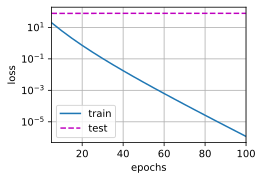

In [7]:
train(lambd=0)

**2.使用权重衰退**

w的L2范数是： 0.3559263348579407


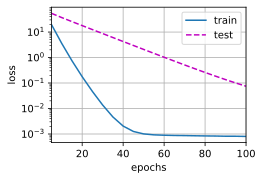

In [8]:
train(lambd=3)

#### b.简洁实现
- 训练代码

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 0.46571749448776245


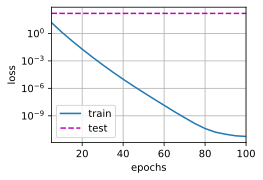

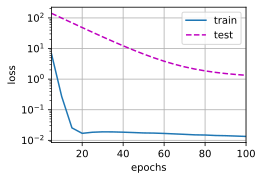

In [10]:
train_concise(0)
train_concise(3)

## 四、Dropout（丢弃法）
- 一个好的模型需要对输入数据的扰动鲁棒
- 丢弃法：在层间加入噪音，相当于一个正则
### 1.无偏差的加入噪音
- 固定住其他层,每一层的期望值等于没有噪音时的值
- 从均值为零的分布$\epsilon \sim \mathcal{N}(0,\sigma^2)$采样噪声添加到输入$\mathbf{x}$,从而产生扰动点$\mathbf{x}' = \mathbf{x} + \epsilon$,期望是$E[\mathbf{x}'] = \mathbf{x}$
- 在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。 换言之，每个中间活性值 h 以暂退概率 p 由随机变量 h′ 替换。
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img/202201212102077.png)
- 期望值保持不变，即 $E[h'] = h$

### 2.实践中的丢弃法
- 通常将丢弃法作用在隐藏全连接的输出上
- 丢弃法只作用在训练过程中
- 推理时，不使用丢弃法，即输入什么就输出什么

### 3.丢弃法的理论总结
- 丢弃法将一些输出项随机置为0来控制模型复杂度
- 常作用在多层感知机的隐藏输出上
- 丢弃概率是控制模型复杂度的超参数

### 4.从零实现DropOut
#### a.实现dropout_layer函数

In [15]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

#### b.测试dropout_layer函数

In [18]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  8.,  0.,  0.,  0.],
        [ 0., 18., 20., 22.,  0.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


#### c.定义感知机

In [19]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

#### d.训练和测试

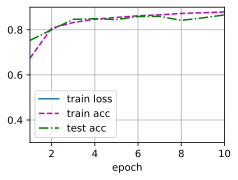

In [20]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 5.简洁实现Dropout

In [21]:
dropout1, dropout2 = 0.2, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

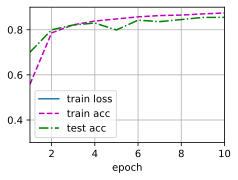

In [22]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 五、数值稳定性
### 1.常见的两个问题
- 梯度爆炸
- 梯度消失
### 2.梯度爆炸
- 值超出值域（infinity）
- 对学习率敏感
    - 如果学习率太大->大参数->更大的梯度
    - 如果学习率太小->训练无进展

### 3.梯度消失
**如图使用sigmoid作为激活函数：**
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img/202201221657776.svg)
- 当输入值很大或者很小的时候，梯度为趋近0，几乎就是0.即梯度消失。
- 当反向传播通过许多层时，除非我们在刚刚好的地方， 这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失
- 当我们的网络有很多层时，除非我们很小心，否则在某一层可能会切断梯度
- 因此，更稳定的ReLU系列函数已经成为从业者的默认选择